In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from stratpd.plot import *
from stratpd.ice import *

%config InlineBackend.figure_formats = ['png']

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

# Auto-MPG

In [2]:
def lm_plot(X, y, colname, targetname,ax=None):
    r_col = LinearRegression()
    r_col.fit(X[[colname]], y)
    ax.scatter(X[colname], y, alpha=.12)
    ax.set_xlabel(colname)
    ax.set_ylabel(targetname)
    ax.set_title(targetname+" vs "+colname)
    col = X[colname]
    y_pred_hp = r_col.predict(col.values.reshape(-1, 1))
    ax.plot(col, y_pred_hp, ":", linewidth=1, c='red', label='OLS y ~ horsepower')
    r = LinearRegression()
    r.fit(X, y)
    xcol = np.linspace(np.min(col), np.max(col), num=100)
    ci = X.columns.get_loc(colname)
    ax.plot(xcol, xcol * r.coef_[ci] + r_col.intercept_, linewidth=1, c='orange', label="Beta_horsepower")
    left30 = xcol[int(len(xcol) * .3)]
    ax.text(left30, left30*r.coef_[ci] + r_col.intercept_, f"slope={r.coef_[ci]:.3f}")
    ax.legend()

In [3]:
df_cars = pd.read_csv("data/auto-mpg.csv")
df_cars = df_cars[df_cars['horsepower']!='?'] # drop the few missing values
df_cars['horsepower'] = df_cars['horsepower'].astype(float)
df_cars.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


collect_leaf_slopes 2.473s
collect_leaf_slopes 1.231s
ICE_predict 0.100s
ICE_predict 0.254s


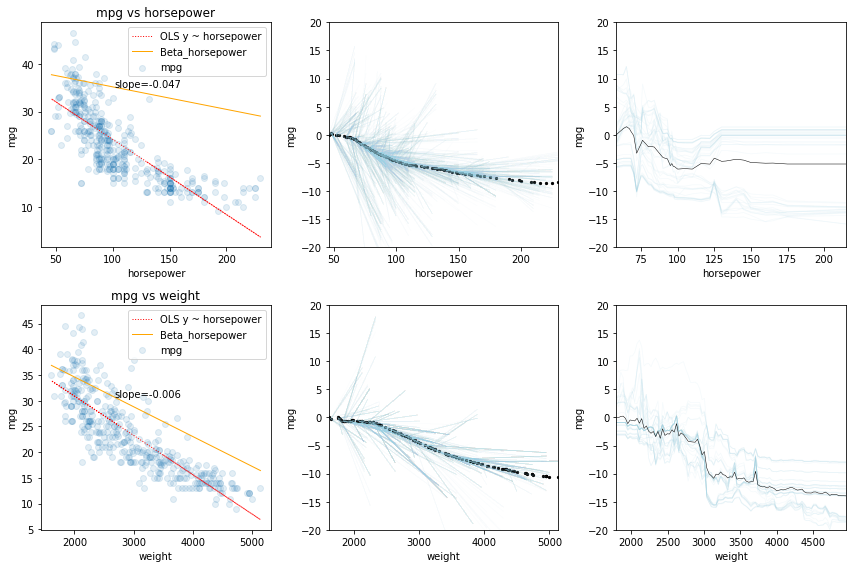

In [4]:
X = df_cars[['horsepower', 'weight']]
y = df_cars['mpg']

fig, axes = plt.subplots(2, 3, figsize=(12,8))
lm_plot(X, y, 'horsepower', 'mpg', ax=axes[0,0])
stratpd_plot(X, y, 'horsepower', 'mpg', ax=axes[0,1], yrange=(-20,20), hires_threshold=30)

lm_plot(X, y, 'weight', 'mpg', ax=axes[1,0])
stratpd_plot(X, y, 'weight', 'mpg', ax=axes[1,1], yrange=(-20,20), hires_threshold=30)

rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)
ice = ice_predict(rf, X, 'horsepower', 'mpg', nlines=50, numx=None)
ice_plot(ice, 'horsepower', 'mpg', ax=axes[0, 2], yrange=(-20,20))
ice = ice_predict(rf, X, 'weight', 'mpg', nlines=50, numx=100)
ice_plot(ice, 'weight', 'mpg', ax=axes[1, 2], yrange=(-20,20))

plt.tight_layout()

plt.show()

# NYC apt rent

## Download, prep data

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data) and save `train.json` into the `data` directory underneath this notebook.

In [5]:
df = pd.read_json('data/train.json')

# Create ideal numeric data set w/o outliers etc...
# Create ideal numeric data set w/o outliers etc...
df = df[(df.price > 1_000) & (df.price < 10_000)]
df = df[df.bathrooms <= 3]  # There's almost no data for 3.5 and above with small sample
df = df[(df.longitude != 0) | (df.latitude != 0)]
df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
        (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]
df_rent.head()

,bedrooms,bathrooms,latitude,longitude,price
10,3,1.5,40.7145,-73.9425,3000
10000,2,1.0,40.7947,-73.9667,5465
100004,1,1.0,40.7388,-74.0018,2850
100007,1,1.0,40.7539,-73.9677,3275
100013,4,1.0,40.8241,-73.9493,3350


collect_leaf_slopes 7.811s
collect_leaf_slopes 6.245s
collect_leaf_slopes 7.849s
collect_leaf_slopes 8.058s
ICE_predict 0.667s
ICE_predict 0.720s
ICE_predict 0.652s
ICE_predict 0.574s


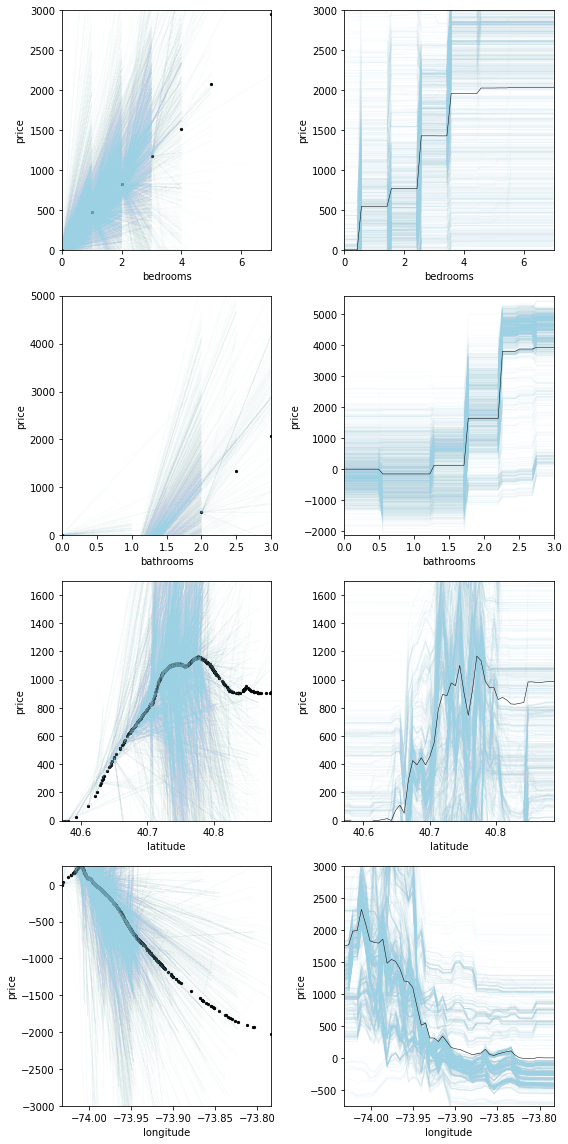

In [6]:
df_rent = df_rent.sample(n=1500)  # get a small subsample
X = df_rent.drop('price', axis=1)
y = df_rent['price']

fig, axes = plt.subplots(4, 2, figsize=(8,16))
stratpd_plot(X, y, 'bedrooms', 'price', ax=axes[0,0], alpha=.03, yrange=(0,3000))
stratpd_plot(X, y, 'bathrooms', 'price', ax=axes[1,0], alpha=.03, yrange=(0,5000))
stratpd_plot(X, y, 'latitude', 'price', ax=axes[2,0], alpha=.03, yrange=(0,1700))
stratpd_plot(X, y, 'longitude', 'price', ax=axes[3,0], alpha=.03, yrange=(-3000,250))

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)

# rf = Lasso()
# rf.fit(X, y)

ice = ice_predict(rf, X, 'bedrooms', 'price')
ice_plot(ice, 'bedrooms', 'price', ax=axes[0, 1], alpha=.05, yrange=(0,3000))
ice = ice_predict(rf, X, 'bathrooms', 'price')
ice_plot(ice, 'bathrooms', 'price', alpha=.05, ax=axes[1, 1])
ice = ice_predict(rf, X, 'latitude', 'price')
ice_plot(ice, 'latitude', 'price', ax=axes[2, 1], alpha=.05, yrange=(0,1700))
ice = ice_predict(rf, X, 'longitude', 'price')
ice_plot(ice, 'longitude', 'price', ax=axes[3, 1], alpha=.05, yrange=(-750,3000))

plt.tight_layout()
plt.show()

## Linear model

collect_leaf_slopes 7.657s
collect_leaf_slopes 6.261s
collect_leaf_slopes 8.005s
collect_leaf_slopes 8.475s
ICE_predict 0.025s
ICE_predict 0.027s
ICE_predict 0.026s
ICE_predict 0.028s


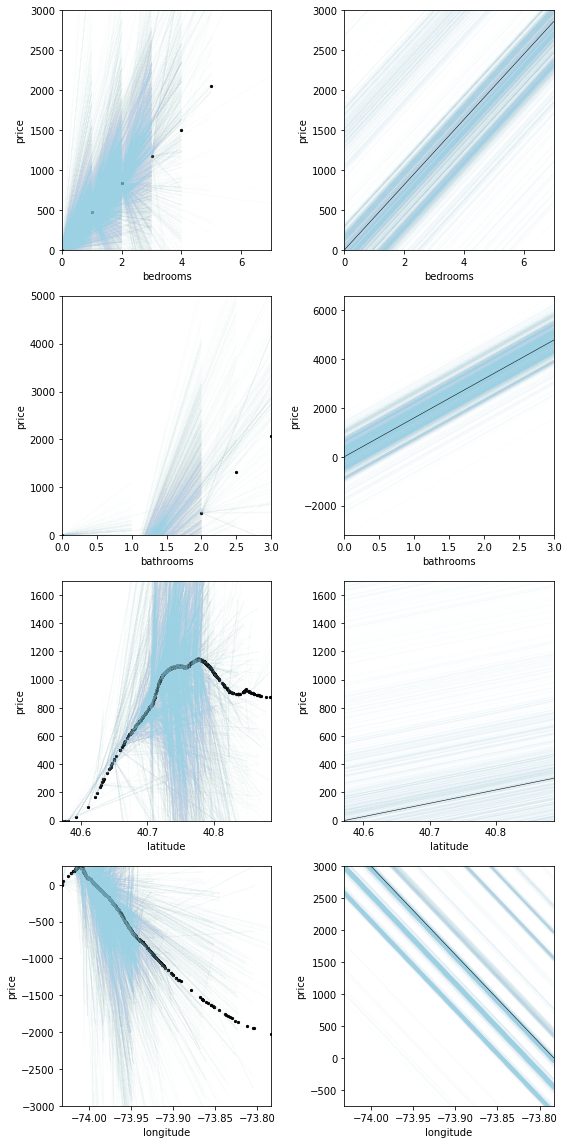

In [7]:
df_rent = df_rent.sample(n=1500)  # get a small subsample
X = df_rent.drop('price', axis=1)
y = df_rent['price']

fig, axes = plt.subplots(4, 2, figsize=(8,16))
stratpd_plot(X, y, 'bedrooms', 'price', ax=axes[0,0], alpha=.03, yrange=(0,3000))
stratpd_plot(X, y, 'bathrooms', 'price', ax=axes[1,0], alpha=.03, yrange=(0,5000))
stratpd_plot(X, y, 'latitude', 'price', ax=axes[2,0], alpha=.03, yrange=(0,1700))
stratpd_plot(X, y, 'longitude', 'price', ax=axes[3,0], alpha=.03, yrange=(-3000,250))

rf = Lasso()
rf.fit(X, y)

ice = ice_predict(rf, X, 'bedrooms', 'price')
ice_plot(ice, 'bedrooms', 'price', ax=axes[0, 1], alpha=.05, yrange=(0,3000))
ice = ice_predict(rf, X, 'bathrooms', 'price')
ice_plot(ice, 'bathrooms', 'price', alpha=.05, ax=axes[1, 1])
ice = ice_predict(rf, X, 'latitude', 'price')
ice_plot(ice, 'latitude', 'price', ax=axes[2, 1], alpha=.05, yrange=(0,1700))
ice = ice_predict(rf, X, 'longitude', 'price')
ice_plot(ice, 'longitude', 'price', ax=axes[3, 1], alpha=.05, yrange=(-750,3000))

plt.tight_layout()
plt.show()

# Synthetic human weight data

In [8]:
def toy_weight_data(n):
    df = pd.DataFrame()
    nmen = n//2
    nwomen = n//2
    df['ID'] = range(100,100+n)
    df['sex'] = ['M']*nmen + ['F']*nwomen
    df.loc[df['sex']=='F','pregnant'] = np.random.randint(0,2,size=(nwomen,))
    df.loc[df['sex']=='M','pregnant'] = 0
    df.loc[df['sex']=='M','height'] = 5*12+8 + np.random.uniform(-7, +8, size=(nmen,))
    df.loc[df['sex']=='F','height'] = 5*12+5 + np.random.uniform(-4.5, +5, size=(nwomen,))
    df.loc[df['sex']=='M','education'] = 10 + np.random.randint(0,8,size=nmen)
    df.loc[df['sex']=='F','education'] = 12 + np.random.randint(0,8,size=nwomen)
    df['weight'] = 120 \
                   + (df['height']-df['height'].min()) * 10 \
                   + df['pregnant']*30 \
                   - df['education']*1.2
    df['pregnant'] = df['pregnant'].astype(bool)
    df['education'] = df['education'].astype(int)
    return df

collect_leaf_slopes 12.491s
collect_leaf_slopes 12.597s
Model wo sex OOB R^2 0.99902
catwise_leaves 20.597s
Model wo pregnant OOB R^2 0.91614
catwise_leaves 23.837s
ICE_predict 1.058s
ICE_predict 0.546s
ICE_predict 1.144s
ICE_predict 1.049s


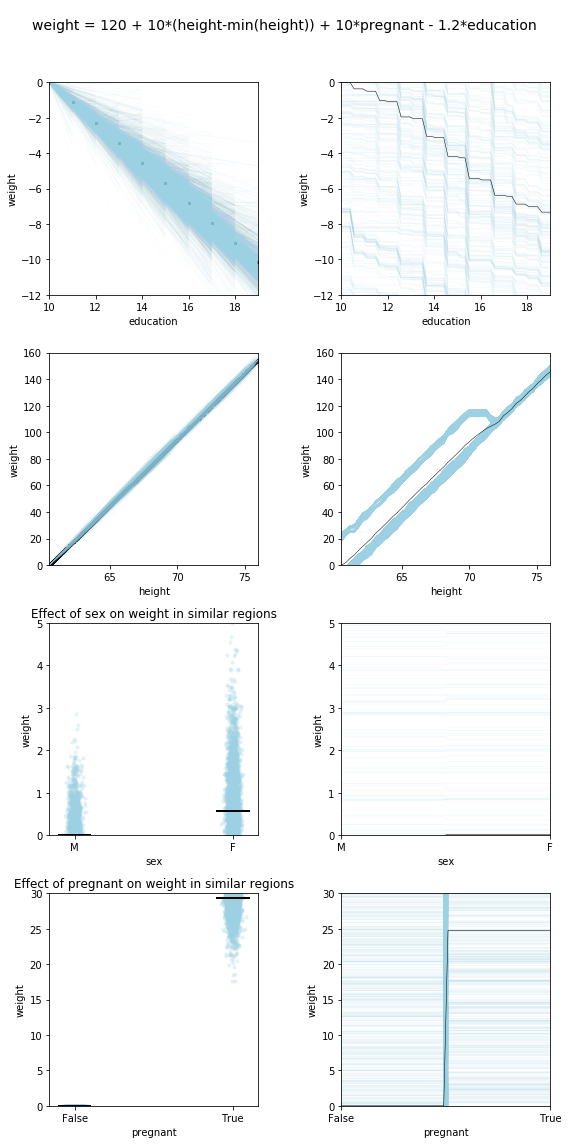

In [9]:
df_raw = toy_weight_data(2000)
df = df_raw.copy()
catencoders = df_string_to_cat(df)
df_cat_to_catcode(df)
df['pregnant'] = df['pregnant'].astype(int)
X = df.drop('weight', axis=1)
y = df['weight']

fig, axes = plt.subplots(5, 2, figsize=(8,16), gridspec_kw = {'height_ratios':[.2,3,3,3,3]})

axes[0,0].get_xaxis().set_visible(False)
axes[0,1].get_xaxis().set_visible(False)
axes[0,0].axis('off')
axes[0,1].axis('off')

stratpd_plot(X, y, 'education', 'weight', ax=axes[1][0],
             yrange=(-12,0),
             )
stratpd_plot(X, y, 'height', 'weight', ax=axes[2][0],
             yrange=(0,160),
             )
catstratpd_plot(X, y, 'sex', 'weight', ax=axes[3][0], ntrees=50,
                 alpha=.2,
                 cats=df_raw['sex'].unique(),
                 yrange=(0,5)
                 )
catstratpd_plot(X, y, 'pregnant', 'weight', ax=axes[4][0], ntrees=50,
                 alpha=.2,
                 cats=df_raw['pregnant'].unique(),
                 yrange=(0,30)
                 )

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)

ice = ice_predict(rf, X, 'education', 'weight')
ice_plot(ice, 'education', 'weight', ax=axes[1, 1], yrange=(-12, 0))
ice = ice_predict(rf, X, 'height', 'weight')
ice_plot(ice, 'height', 'weight', ax=axes[2, 1], yrange=(0, 160))
ice = ice_predict(rf, X, 'sex', 'weight')
ice_plot(ice, 'sex', 'weight', ax=axes[3,1], yrange=(0,5), cats=df_raw['sex'].unique())
ice = ice_predict(rf, X, 'pregnant', 'weight')
ice_plot(ice, 'pregnant', 'weight', ax=axes[4,1], yrange=(0,30), cats=df_raw['pregnant'].unique())

fig.suptitle("weight = 120 + 10*(height-min(height)) + 10*pregnant - 1.2*education", size=14)

plt.tight_layout()

# Reproduce variable interaction "big X" data from ICE paper

Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation by Alex Goldstein, Adam Kapelner†, Justin Bleich‡, and Emil Pitkin. https://arxiv.org/abs/1309.6392#

In [10]:
def bigX_data(n):
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-1, 1, size=n)
    x3 = np.random.uniform(-1, 1, size=n)

    y = 0.2 * x1 - 5 * x2 + 10 * x2 * np.where(x3 >= 0, 1, 0) + np.random.normal(0, 1, size=n)
    df = pd.DataFrame()
    df['x1'] = x1
    df['x2'] = x2
    df['x3'] = x3
    df['y'] = y
    return df

collect_leaf_slopes 5.707s
collect_leaf_slopes 5.607s
collect_leaf_slopes 5.512s
RF OOB 0.8554747771315845
ICE_predict 0.125s
ICE_predict 0.096s
ICE_predict 0.115s


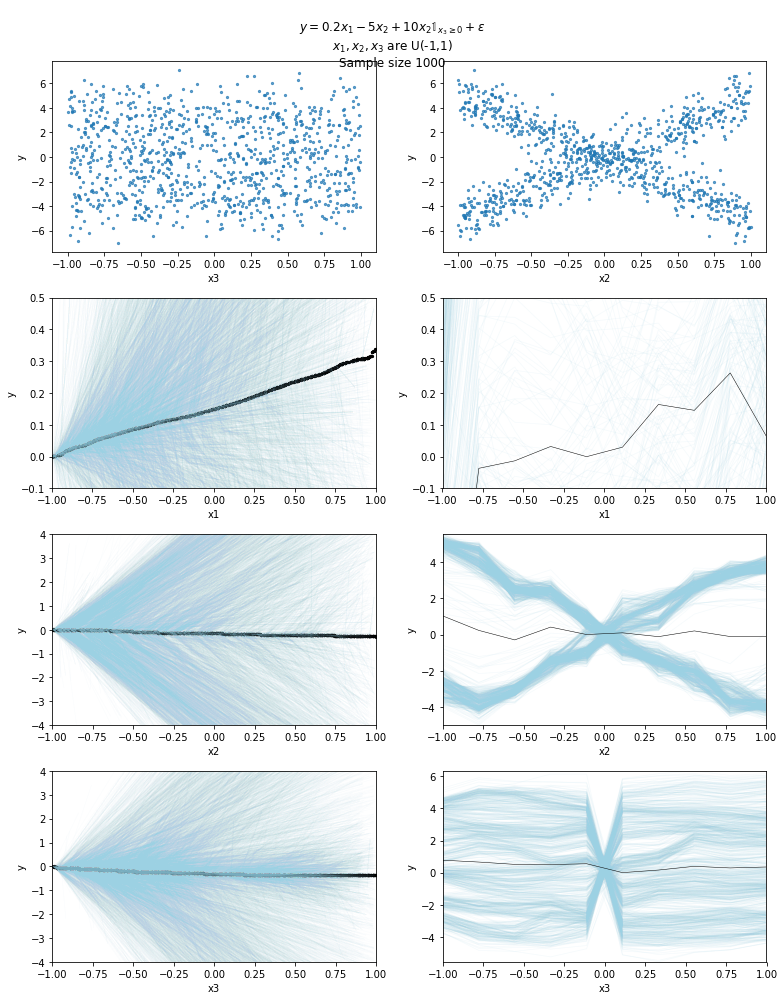

In [11]:
n = 1000
df = bigX_data(n=n)
X = df.drop('y', axis=1)
y = df['y']

fig, axes = plt.subplots(5, 2, figsize=(11, 14), gridspec_kw = {'height_ratios':[.1,4,4,4,4]})

axes[0, 0].get_xaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 0].axis('off')
axes[0, 1].axis('off')

axes[1,0].scatter(df['x3'], y, s=5, alpha=.7)
axes[1,0].set_xlabel('x3')
axes[1,0].set_ylabel('y')

axes[1,1].scatter(df['x2'], df['y'], s=5, alpha=.7)
axes[1,1].set_ylabel('y')
axes[1,1].set_xlabel('x2')

# Partial deriv is just 0.2 so this is correct. flat deriv curve, net effect line at slope .2
# ICE is way too shallow and not line at n=1000 even
stratpd_plot(X, y, 'x1', 'y', ax=axes[2,0], yrange=(-.1,.5))
# Partial deriv wrt x2 is -5 plus 10 about half the time so about 0
# Should not expect a criss-cross like ICE since deriv of 1_x3>=0 is 0 everywhere
# wrt to any x, even x3. x2 *is* affecting y BUT the net effect at any spot
# is what we care about and that's 0. Just because marginal x2 vs y shows non-
# random plot doesn't mean that x2's net effect is nonzero. We are trying to
# strip away x1/x3's effect upon y. When we do, x2 has no effect on y.
# Key is asking right question. Don't look at marginal plot and say obvious.
# Ask what is net effect at every x2? 0.
stratpd_plot(X, y, 'x2', 'y', ax=axes[3,0], yrange=(-4,4))
# Partial deriv wrt x3 of 1_x3>=0 is 0 everywhere so result must be 0
stratpd_plot(X, y, 'x3', 'y', ax=axes[4,0], yrange=(-4,4))

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)
print(f"RF OOB {rf.oob_score_}")

ice = ice_predict(rf, X, 'x1', 'y', numx=10)
ice_plot(ice, 'x1', 'y', ax=axes[2, 1], yrange=(-.1,.5))

ice = ice_predict(rf, X, 'x2', 'y', numx=10)
ice_plot(ice, 'x2', 'y', ax=axes[3, 1])

ice = ice_predict(rf, X, 'x3', 'y', numx=10)
ice_plot(ice, 'x3', 'y', ax=axes[4, 1])

fig.suptitle("$y = 0.2x_1 - 5x_2 + 10x_2\mathbb{1}_{x_3 \geq 0} + \epsilon$\n$x_1, x_2, x_3$ are U(-1,1)\nSample size "+str(n))
plt.tight_layout()
plt.show()

# Toy weather data with sine curve

In [12]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from mine.plot import *
from mine.ice import *

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [13]:
def toy_weather_data():
    def temp(x): return np.sin((x+365/2)*(2*np.pi)/365)
    def noise(state): return np.random.normal(-5, 5, sum(df['state'] == state))

    df = pd.DataFrame()
    df['dayofyear'] = range(1,365+1)
    df['state'] = np.random.choice(['CA','CO','AZ','WA'], len(df))
    df['temperature'] = temp(df['dayofyear'])
    df.loc[df['state']=='CA','temperature'] = 70 + df.loc[df['state']=='CA','temperature'] * noise('CA')
    df.loc[df['state']=='CO','temperature'] = 40 + df.loc[df['state']=='CO','temperature'] * noise('CO')
    df.loc[df['state']=='AZ','temperature'] = 90 + df.loc[df['state']=='AZ','temperature'] * noise('AZ')
    df.loc[df['state']=='WA','temperature'] = 60 + df.loc[df['state']=='WA','temperature'] * noise('WA')
    return df

{'state': Index(['AZ', 'CA', 'CO', 'WA'], dtype='object')}
collect_leaf_slopes 10.565s
Model wo state OOB R^2 -0.09922
catwise_leaves 2.542s
ICE_predict 0.101s
ICE_predict 0.104s


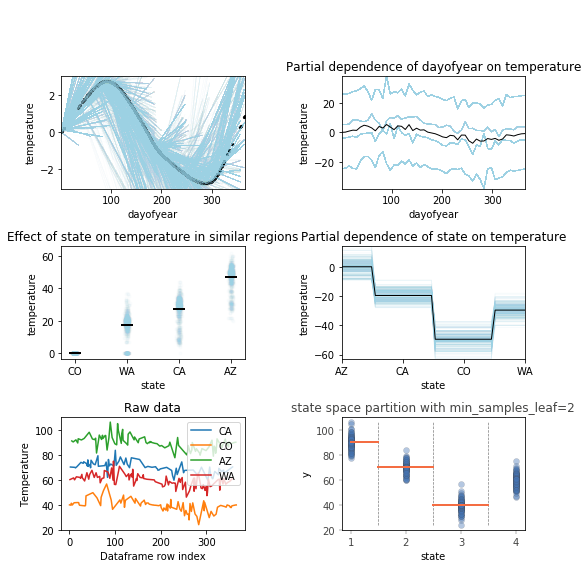

In [14]:
df_raw = toy_weather_data()
df = df_raw.copy()
catencoders = df_string_to_cat(df)
print(catencoders)
df_cat_to_catcode(df)
X = df.drop('temperature', axis=1)
y = df['temperature']

fig, axes = plt.subplots(4, 2, figsize=(8,8), gridspec_kw = {'height_ratios':[.2,3,3,3]})

axes[0,0].get_xaxis().set_visible(False)
axes[0,1].get_xaxis().set_visible(False)
axes[0,0].axis('off')
axes[0,1].axis('off')

"""
The scale diff between states, obscures the sinusoidal nature of the
dayofyear vs temp plot. With noise N(0,5) gotta zoom in -3,3 on mine too.
otherwise, smooth quasilinear plot with lots of bristles showing volatility.
Flip to N(-5,5) which is more realistic and we see sinusoid for both, even at
scale. yep, the N(0,5) was obscuring sine for both. 
"""
stratpd_plot(X, y, 'dayofyear', 'temperature', ax=axes[1][0],
             ntrees=50, min_samples_leaf=2)#, yrange=(-10,10))
catstratpd_plot(X, y, 'state', 'temperature', cats=catencoders['state'], ax=axes[2][0])#, yrange=(0,160))

rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)

ice = ice_predict(rf, X, 'dayofyear', 'temperature')
ice_plot(ice, 'dayofyear', 'temperature', ax=axes[1, 1])  #, yrange=(-12,0))

ice = ice_predict(rf, X, 'state', 'temperature')
ice_plot(ice, 'state', 'temperature', cats=catencoders['state'], ax=axes[2, 1])  #, yrange=(-12,0))

df = df_raw.copy()
axes[3, 0].plot(df.loc[df['state'] == 'CA', 'dayofyear'],
         df.loc[df['state'] == 'CA', 'temperature'], label="CA")
axes[3, 0].plot(df.loc[df['state'] == 'CO', 'dayofyear'],
         df.loc[df['state'] == 'CO', 'temperature'], label="CO")
axes[3, 0].plot(df.loc[df['state'] == 'AZ', 'dayofyear'],
         df.loc[df['state'] == 'AZ', 'temperature'], label="AZ")
axes[3, 0].plot(df.loc[df['state'] == 'WA', 'dayofyear'],
         df.loc[df['state'] == 'WA', 'temperature'], label="WA")
axes[3, 0].legend()
axes[3,0].set_title('Raw data')
axes[3, 0].set_ylabel('Temperature')
axes[3, 0].set_xlabel('Dataframe row index')

rtreeviz_univar(axes[3,1],
                X['state'], y,
                feature_name='state',
                target_name='y',
                min_samples_leaf=2,
                fontsize=10)
axes[3,1].set_title(f'state space partition with min_samples_leaf={2}')
axes[3,1].set_xlabel("state")
axes[3,1].set_ylabel("y")

plt.tight_layout()

plt.show()

# Boston housing data set

In [15]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


collect_leaf_slopes 2.982s
RF OOB 0.8681311113145966
ICE_predict 0.087s


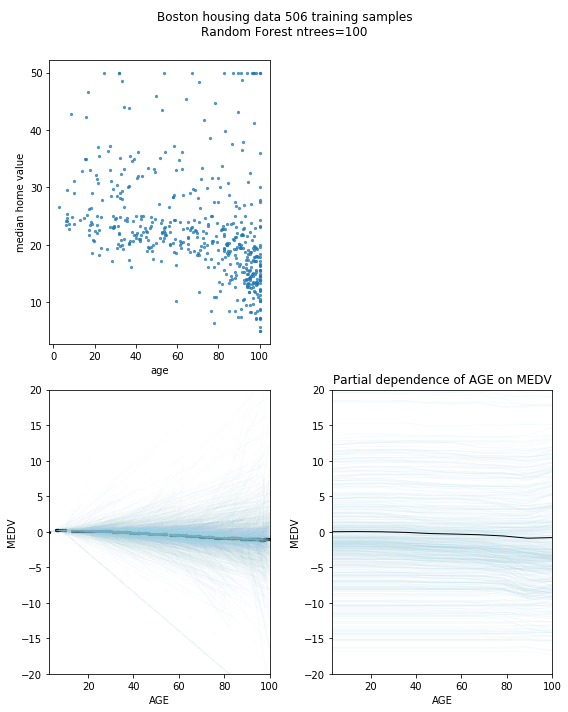

In [16]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

"""
Wow. My net effect plots look kinda like the centered ICE c-ICE plots
from paper: https://arxiv.org/pdf/1309.6392.pdf
Mine are way smoother.
"""
fig, axes = plt.subplots(3, 2, figsize=(8, 10), gridspec_kw = {'height_ratios':[.05,4,4]})

axes[0, 0].get_xaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 0].axis('off')
axes[0, 1].axis('off')

axes[1,0].scatter(df['AGE'], y, s=5, alpha=.7)
axes[1,0].set_xlabel('age')
axes[1,0].set_ylabel('median home value')
axes[1, 1].axis('off')

stratpd_plot(X, y, 'AGE', 'MEDV', ax=axes[2,0], yrange=(-20,20))

rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(X, y)
print(f"RF OOB {rf.oob_score_}")

ice = ice_predict(rf, X, 'AGE', 'MEDV', numx=10)
ice_plot(ice, 'AGE', 'MEDV', ax=axes[2, 1], yrange=(-20,20))

fig.suptitle(f"Boston housing data {len(X)} training samples\nRandom Forest ntrees=100")
plt.tight_layout()
plt.show()

# Simple interaction of variables

In [17]:
def interaction(f, n=100, min_samples_leaf=5, ntrees=30):
    df,eqn,yrange = f(n=n)

    X = df.drop('y', axis=1)
    y = df['y']

    fig, axes = plt.subplots(4, 2, figsize=(10,13))

    axes[0,0].plot(range(len(df)), df['x1'], label="x1")
    axes[0,0].plot(range(len(df)), df['x2'], label="x2")
    axes[0,0].plot(range(len(df)), df['y'], label="y")
    axes[0, 0].set_xlabel("df row index")
    axes[0, 0].set_ylabel("df value")
    axes[0, 0].legend()
    axes[0, 0].set_title(f"Raw data; {eqn}")

    # axes[0,1].get_xaxis().set_visible(False)
    # axes[0,1].axis('off')

    rtreeviz_univar(axes[0,1],
                    df['x1'], y,
                    feature_name='x1',
                    target_name='y',
                    min_samples_leaf=min_samples_leaf,
                    fontsize=10)
    axes[0,1].set_title(f'x1 space partition with min_samples_leaf={min_samples_leaf}')
    axes[0,1].set_xlabel("x1")
    axes[0,1].set_ylabel("y")

    # print(df)
    # print(f"x1 = {df['x1'].values.tolist()}")
    # print(f"x2 = {df['x2'].values.tolist()}")
    # print(f"y = {df['y'].values.tolist()}")
    axes[1,0].scatter(df['x1'], y)
    axes[1,0].set_xlabel("x1")
    axes[1,0].set_ylabel("y")
    axes[1,1].scatter(df['x2'], y)
    axes[1,1].set_xlabel("x2")
    axes[1,1].set_ylabel("y")

    stratpd_plot(X, y, 'x1', 'y', ax=axes[2][0],
                 ntrees=ntrees, min_samples_leaf=min_samples_leaf, yrange=yrange)
    # partial_plot(X, y, 'education', 'weight', ntrees=20, min_samples_leaf=7, alpha=.2)
    stratpd_plot(X, y, 'x2', 'y', ax=axes[3][0], min_samples_leaf=min_samples_leaf,
                 ntrees=ntrees, yrange=yrange)
    # cat_partial_plot(axes[2][0], X, y, 'sex', 'weight', ntrees=50, min_samples_leaf=7, cats=df_raw['sex'].unique(), yrange=(0,2))
    # cat_partial_plot(axes[3][0], X, y, 'pregnant', 'weight', ntrees=50, min_samples_leaf=7, cats=df_raw['pregnant'].unique(), yrange=(0,10))

    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
    rf.fit(X, y)

    ice = ice_predict(rf, X, 'x1', 'y', numx=None)
    ice_plot(ice, 'x1', 'y', ax=axes[2, 1], yrange=yrange)
    ice = ice_predict(rf, X, 'x2', 'y', numx=None)
    ice_plot(ice, 'x2', 'y', ax=axes[3, 1], yrange=yrange)

    plt.tight_layout()
    plt.show()

In [18]:
def toy_x1_times_x2_data(n=1000):
    df = pd.DataFrame()
    df['x1'] = np.random.uniform(0, 1, size=n)
    df['x2'] = np.random.uniform(0, 1, size=n)
    df['y'] = df['x1'] * df['x2']# + df['x1'] + df['x2']
    return df, f"y = x1x2\nx1, x2 in U(0,1)", (0,.6)

collect_leaf_slopes 0.236s
collect_leaf_slopes 0.232s
ICE_predict 0.393s
ICE_predict 0.444s


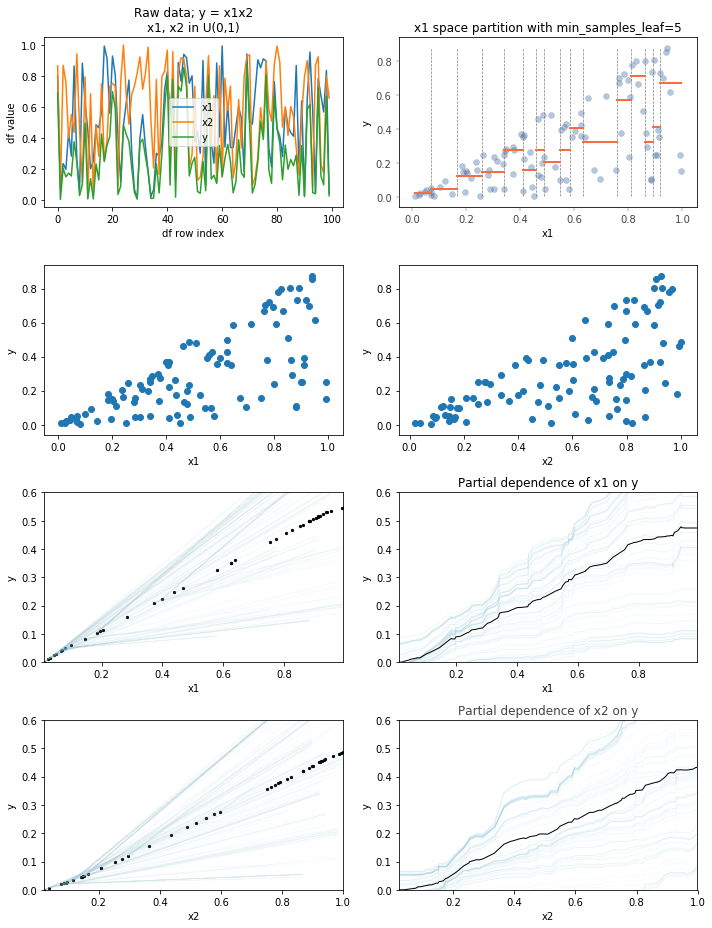

In [19]:
interaction(toy_x1_times_x2_data, min_samples_leaf=5)

In [20]:
def toy_2x1_times_3x2_data(n=1000):
    df = pd.DataFrame()
    df['x1'] = np.random.uniform(0, 1, size=n)
    df['x2'] = np.random.uniform(0, 1, size=n)
    df['y'] = 2*df['x1'] * 10*df['x2']# + df['x1'] + df['x2']
    return df, f"y = 2x1 * 10x2\nx1, x2 in U(0,1)", (0,12)

collect_leaf_slopes 7.606s
collect_leaf_slopes 7.172s
ICE_predict 0.405s
ICE_predict 0.409s


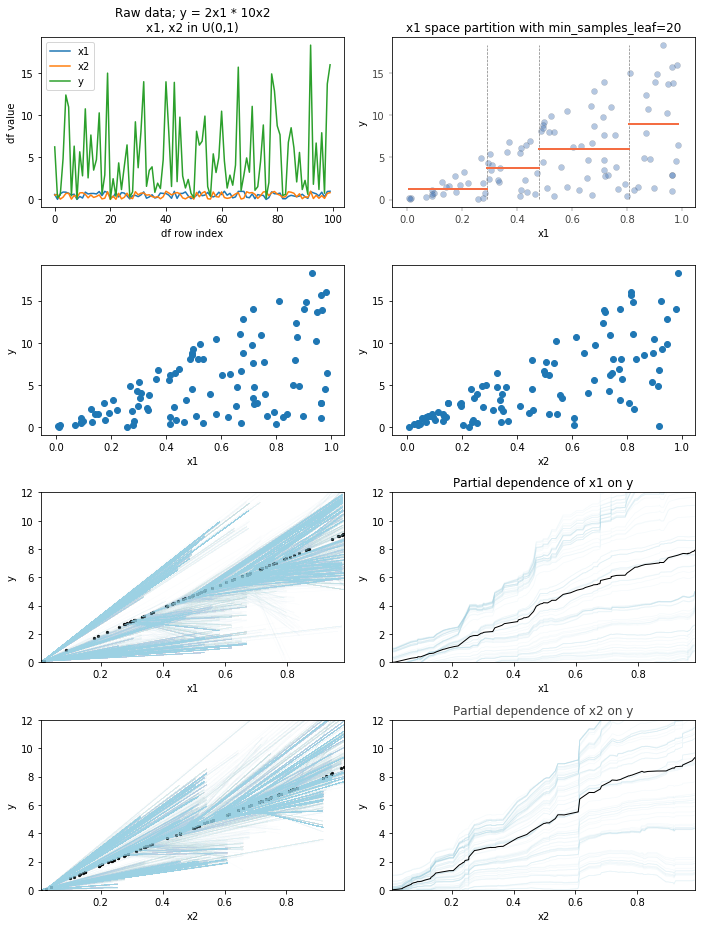

In [21]:
interaction(toy_2x1_times_3x2_data,min_samples_leaf=20, ntrees=100)

# Additivity assessment from ICE paper

In [22]:
def additivity_data(n):
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-1, 1, size=n)

    y = x1*x1 + x2 + np.random.normal(0, 1, size=n)
    df = pd.DataFrame()
    df['x1'] = x1
    df['x2'] = x2
    df['y'] = y
    return df

collect_leaf_slopes 31.710s
collect_leaf_slopes 32.228s
RF OOB 0.1799964391577371
ICE_predict 0.203s
ICE_predict 0.179s


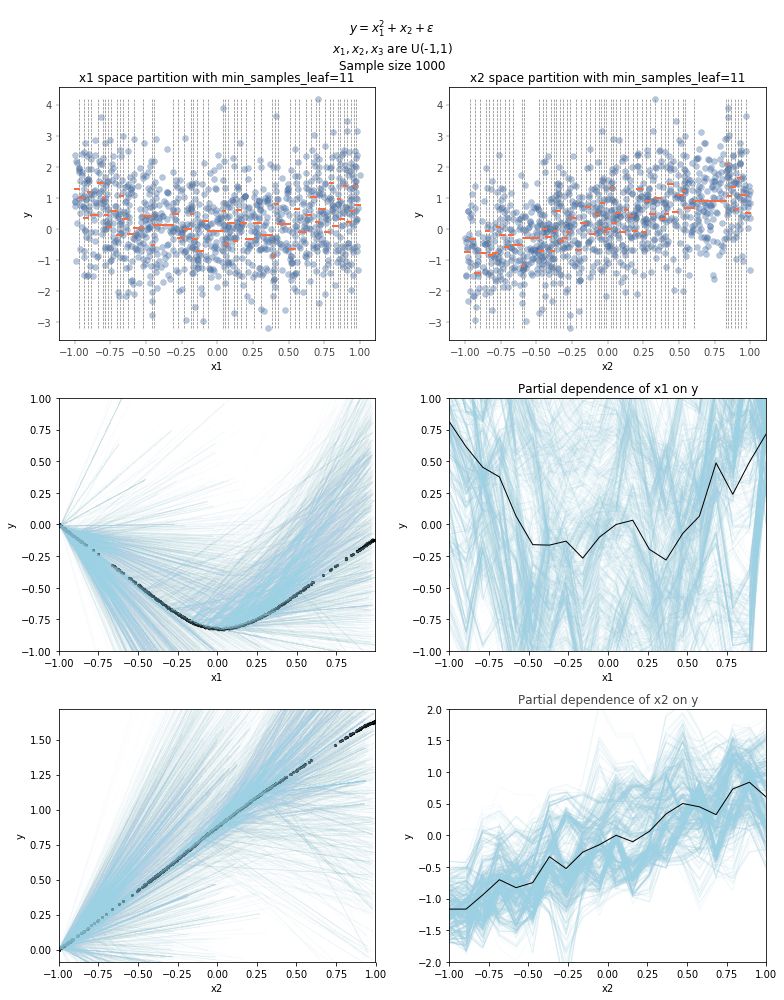

In [23]:
n=1000
df = additivity_data(n=n)
X = df.drop('y', axis=1)
y = df['y']

fig, axes = plt.subplots(4, 2, figsize=(11, 14), gridspec_kw = {'height_ratios':[.3,4,4,4]})

axes[0, 0].get_xaxis().set_visible(False)
axes[0, 0].axis('off')
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 1].axis('off')

# axes[1,0].scatter(df['x1'], y, s=5, alpha=.7)
# axes[1,0].set_xlabel('x1')
# axes[1,0].set_ylabel('y')

"""
When we have too many samples in leaf, we don't get enough detail / points
near zero and it looks like line not parabola.

Mine looks like parabola but U(-3,3) gives max values of 2.5ish for -3 and 3
whereas PDP gives 8 for -3 and 3. n=1000 seems a bit shifted but n=2000 gets
center/base of parabola correctly at x1=0.

When one is shallow like a line then leaf might get lots of values and
therefore bad slope estimate. Just two vars like y=x1^2 + x2 shows us biased
too low for x1. 

oh shit. the RF is bootstrapping and missing lots of values. try all.
Make max_features=1.0 too. we don't care about overfitting here, do we?

Turning off bootstrap (no replace, but same sample size) gets much taller
parabola, though max_features=1.0 didn't do much.
"""
min_samples_leaf = 11
rtreeviz_univar(axes[1,0],
                df['x1'], y,
                feature_name='x1',
                target_name='y',
                min_samples_leaf=min_samples_leaf,
                fontsize=10)
axes[1,0].set_title(f'x1 space partition with min_samples_leaf={min_samples_leaf}')
axes[1,0].set_xlabel("x1")
axes[1,0].set_ylabel("y")

rtreeviz_univar(axes[1,1],
                df['x2'], y,
                feature_name='x2',
                target_name='y',
                min_samples_leaf=min_samples_leaf,
                fontsize=10)
axes[1,1].set_title(f'x2 space partition with min_samples_leaf={min_samples_leaf}')
axes[1,1].set_xlabel("x2")
axes[1,1].set_ylabel("y")

stratpd_plot(X, y, 'x1', 'y', ax=axes[2,0], min_samples_leaf=min_samples_leaf, hires_threshold=10, yrange=(-1,1))
stratpd_plot(X, y, 'x2', 'y', ax=axes[3,0], min_samples_leaf=min_samples_leaf, hires_threshold=10)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)
print(f"RF OOB {rf.oob_score_}")

ice = ice_predict(rf, X, 'x1', 'y', numx=20)
ice_plot(ice, 'x1', 'y', ax=axes[2, 1], yrange=(-1,1))

ice = ice_predict(rf, X, 'x2', 'y', numx=20)
ice_plot(ice, 'x2', 'y', ax=axes[3, 1], yrange=(-2,2))

fig.suptitle("$y = x_1^2 + x_2 + \epsilon$\n$x_1, x_2, x_3$ are U(-1,1)\nSample size "+str(n))
plt.tight_layout()
plt.show()

# Wine classifier

In [24]:
from mine.plot import *
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['wine'] = wine.target
df.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [25]:
df['wine'].value_counts()

1    71
0    59
2    48
Name: wine, dtype: int64

In [26]:
colname = 'proline'
targetname='wine'

X = df.drop(targetname, axis=1)
y = df[targetname].astype(int)

rf = RandomForestRegressor(n_estimators=3,
                           min_samples_leaf=3,
                           oob_score=False)
rf.fit(X.drop(colname,axis=1), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
ncats = len(np.unique(y))
nbins = 10
overall_range = (np.min(X[colname]), np.max(X[colname]))
#np.linspace(*overall_range, nbins)
from sklearn.preprocessing import KBinsDiscretizer
bin = KBinsDiscretizer(n_bins=nbins, strategy='uniform', encode='ordinal')
bin.fit(X[[colname]], y)

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [28]:
leaves = leaf_samples(rf, X.drop(colname, axis=1))
samples = leaves[3]
one_leaf_samples = X.iloc[samples]
leaf_x = one_leaf_samples[colname].values
leaf_y = y.iloc[samples].values
Xy = pd.DataFrame(np.array([leaf_x,leaf_y]).T, columns=['xi','y'])
Xy.sort_values('xi')

,xi,y
5,380.0,1.0
3,392.0,1.0
1,410.0,1.0
2,472.0,1.0
0,502.0,1.0
4,515.0,1.0


In [29]:
binned_x = bin.transform(leaf_x.reshape(-1,1)).flatten().astype(int)
Xy['xi'] = binned_x
Xy.sort_values('xi').astype(int)

,xi,y
1,0,1
3,0,1
5,0,1
0,1,1
2,1,1
4,1,1


In [30]:
Xy.groupby('xi')['y'].apply(lambda x:x.values.astype(int))

xi
0    [1, 1, 1]
1    [1, 1, 1]
Name: y, dtype: object

In [31]:
"""
Get ncats-sized array for each xi bin with count of cat values; e.g., for xi->y and 3 cats
	xi	y
1	0	1
2	1	1
3	1	2
0	7	0

we get:

xi
0    [0, 1, 0]
1    [0, 1, 1]
7    [1, 0, 0]
"""
cats_per_bin = Xy.groupby('xi')['y'].apply(lambda x:np.bincount(x.values.astype(int), minlength=ncats))
cats_per_bin

xi
0    [0, 3, 0]
1    [0, 3, 0]
Name: y, dtype: object

In [32]:
cat_changes_per_bin = np.diff(cats_per_bin)
cat_changes_per_bin

array([array([0, 0, 0])], dtype=object)

In [33]:
cat_changes_per_bin = np.vstack(cat_changes_per_bin) # make into matrix (|xi|,ncats) not list of vectors
cat_changes_per_bin

array([[0, 0, 0]])

In [34]:
# get a 0-vector of size ncats as first row for first xi bin
# TODO: maybe should be nan indicating we don't know changes for first bin
# or maybe strip away first bin?
cat_changes_per_bin = np.vstack([np.full(ncats,np.nan), cat_changes_per_bin])
cat_changes_per_bin

array([[nan, nan, nan],
       [ 0.,  0.,  0.]])

In [35]:
Xy

,xi,y
0,1,1.0
1,0,1.0
2,1,1.0
3,0,1.0
4,1,1.0
5,0,1.0


In [36]:
np.array(sorted(binned_x)[1:])

array([0, 0, 1, 1, 1])

In [37]:
np.hstack([np.array(sorted(binned_x)[1:]).reshape(-1,1),cat_changes_per_bin]) # show together

ValueError: all the input array dimensions except for the concatenation axis must match exactly

# Playground

In [ ]:
def collect_leaf_catcounts(X,y):
    catcol = y.astype('category').cat.as_ordered()
    cats = catcol.cat.categories

    leaves = leaf_samples(rf, X.drop(colname, axis=1))
    Xy = pd.concat([X, y], axis=1)
    ncats = len(np.unique(y))
    nleaves = len(leaves)

    leaf_yhistos = pd.DataFrame(index=cats)
    leaf_yhistos.index.name = 'category'

    leaf_xranges = np.zeros(shape=(nleaves, 2, ncats))
    
    leaf_xranges = []

    ci = 0
    for samples in leaves:
        leaf_obs = Xy.iloc[samples]
        ycounts = leaf_obs['wine'].value_counts()
        if len(ycounts) < 2:
#             print(f"ignoring len {len(ycounts)} ycats in leaf")
            continue
#         print(ycounts)
        r = (np.min(leaf_obs[colname]), np.max(leaf_obs[colname]))
        if np.isclose(r[0], r[1]):
            # print(f"ignoring xleft=xright @ {r[0]}")
            continue
#         leaf_xranges[ci,(0,1),0] = r
        leaf_xranges.append(r)
        relative_ycat_changes_for_leaf = ycounts - np.min(ycounts.values)
        leaf_yhistos['leaf' + str(ci)] = relative_ycat_changes_for_leaf
        ci += 1

    leaf_xranges = np.array(leaf_xranges)
    return leaf_xranges, leaf_yhistos

In [ ]:
leaf_xranges, leaf_yhistos = collect_leaf_catcounts(X,y)
leaf_yhistos.head()

In [ ]:
leaf_xranges

In [ ]:
def foo(leaf_xranges, leaf_yhistos):
    uniq_x = set(leaf_xranges[:, 0]).union(set(leaf_xranges[:, 1]))
    uniq_x = np.array(sorted(uniq_x))
    nx = len(uniq_x)
    ncats = len(np.unique(y))
    nleaves = len(leaf_xranges)

    allcounts = []
    ci = 0
    for cat in leaf_yhistos.index:
        counts = np.zeros(shape=(nx, nleaves))
        catcount_in_leaves = leaf_yhistos.loc[cat].values
        print()
        print(cat,'->',catcount_in_leaves)
        i = 0  # leaf index; we get a cat count for each leaf (and per category level)
        for r, catcount in zip(leaf_xranges,catcount_in_leaves):
            c = np.full(nx, catcount) # c has cat value at all x locations (flat line)
            c[np.where(uniq_x < r[0])] = np.nan # wipe out other areas
            c[np.where(uniq_x > r[1])] = np.nan
#             print(catcount)
            counts[:, i] = c
            i += 1
        
        print(counts)
        sum_at_x = np.nansum(counts, axis=1)
        missing_values_at_x = np.isnan(counts).sum(axis=1)
        count_at_x = nleaves - missing_values_at_x
        # The value could be genuinely zero so we use nan not 0 for out-of-range
        avg_count_at_x = sum_at_x / count_at_x
#         print(avg_count_at_x)
        allcounts.append(avg_count_at_x)

        ci += 1

    return uniq_x, np.array(allcounts)

In [ ]:
uniq_x, counts = foo(leaf_xranges, leaf_yhistos)

In [ ]:
counts

In [ ]:
uniq_x

In [ ]:
counts[:,0]

In [ ]:
fig, ax = plt.subplots(1, 1)

for ci in range(0,2+1):
    ax.bar(uniq_x, counts[ci], width=20, alpha=.3)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)

for ci in range(0,2+1):
    ax.bar(uniq_x, counts[ci], width=30, alpha=.3)
plt.show()

## Logistic regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['wine'] = wine.target
df.head(5)

In [ ]:
targetname='wine'
colname = 'proline'

X = df[[colname]]#df.drop(targetname, axis=1)
y = df[targetname]
lowregularization = 100
logr = LogisticRegression(C=lowregularization, multi_class='ovr')
logr.fit(X, y)
logr.predict(X)
logr.coef_.flatten(), logr.intercept_

In [ ]:
fig, ax = plt.subplots(1, 1)

def logodds2prob(x): return 1 / (1 + np.exp(x))

ax.scatter(X[colname].values, y, s=10, c='k')
# ax.scatter(X[colname].values, logr.predict(X[[colname]]), c='maroon', s=3)
y_ = logr.predict(X[[colname]])
coef = logr.coef_.flatten()
y1 = X[colname].values * coef[0] + logr.intercept_[0]
y2 = X[colname].values * coef[1] + logr.intercept_[1]
y3 = X[colname].values * coef[2] + logr.intercept_[2]
p1 = 1-logodds2prob(y1) # sklearn is treating the y values in weird way; needed to flip probabilities
p2 = 1-logodds2prob(y2)
p3 = 1-logodds2prob(y3)
ax.scatter(X[colname].values, p1, label='class1', s=3)
ax.scatter(X[colname].values, p2, label='class2', s=3)
ax.scatter(X[colname].values, p3, label='class3', s=3)

#print(y_)
odds = np.exp(y_).ravel()
#print(f"odds {odds}")
p = odds / (1 + odds)
#print(f"p {p}")
#ax.plot(X.values, sigmoid(y_), c='blue')
#ax.plot(X.values, (expit(lr.predict(X))), c='maroon')

ax.legend()
plt.show()

In [ ]:
def collect_leaf_slopes(rf, X, y, colname, hires_threshold, isclassifier=False):
    """
    For each leaf of each tree of the random forest rf (trained on all features
    except colname), get the samples then isolate the column of interest X values
    and the target y values. Perform a regression to get the slope of X[colname] vs y.
    We don't need to subtract the minimum y value before regressing because
    the slope won't be different. (We are ignoring the intercept of the regression line).

    Return for each leaf, the range of X[colname], y at left/right of leaf range,
    and associated slope for that range.

    Currently, leaf_yranges is unused.
    """
    start = time.time()
    nuniq_y = len(np.unique(y))
    leaf_slopes = []
    leaf_intercepts = []
    leaf_xranges = []
    leaf_yranges = []
    leaves = leaf_samples(rf, X.drop(colname, axis=1))
    for samples in leaves:
        one_leaf_samples = X.iloc[samples]
        leaf_x = one_leaf_samples[colname].values
        leaf_y = y.iloc[samples].values
        r = (np.min(leaf_x), np.max(leaf_x))
        if np.isclose(r[0], r[1]):
            # print(f"ignoring xleft=xright @ {r[0]}")
            continue
        if isclassifier:
            leaf_classes = np.unique(leaf_y)
            if len(leaf_classes)<2:
                continue
            lowregularization = 100
            logr = LogisticRegression(C=lowregularization, multi_class='ovr')
            logr.fit(leaf_x.reshape(-1, 1), leaf_y)
            allcoeff = np.full(nuniq_y, np.nan)
            allintercepts = np.full(nuniq_y, np.nan)
            coeff = logr.coef_.flatten()
            intercepts = logr.intercept_
            if len(coeff)==1:
                # To go from binary case which gives one coeff, negate beta and intercept to get other.
                coeff = np.array([coeff[0], -coeff[0]])
                intercepts = np.array([logr.intercept_[0], -logr.intercept_[0]])
            allcoeff[leaf_classes] = coeff # assumes classes are 0,1,2,...
            allintercepts[leaf_classes] = intercepts
#             print(leaf_classes, allcoeff, allintercepts)
            leaf_slopes.append(allcoeff)
            leaf_intercepts.append(allintercepts)
        else:
            lm = LinearRegression()
            lm.fit(leaf_x.reshape(-1, 1), leaf_y)
            leaf_slopes.append(lm.coef_[0])
            leaf_intercepts.append(lm.intercept_[0])
        leaf_xranges.append(r)
        leaf_yranges.append((leaf_y[0], leaf_y[-1]))
    leaf_slopes = np.array(leaf_slopes)
    leaf_intercepts = np.array(leaf_intercepts)
    leaf_xranges = np.array(leaf_xranges)
    leaf_yranges = np.array(leaf_yranges)
    stop = time.time()
    print(f"collect_leaf_slopes {stop - start:.3f}s")
    return leaf_xranges, leaf_yranges, leaf_slopes, leaf_intercepts

In [ ]:
def avg_slope_at_x(leaf_ranges, leaf_slopes):
    start = time.time()
    uniq_x = set(leaf_ranges[:, 0]).union(set(leaf_ranges[:, 1]))
    uniq_x = np.array(sorted(uniq_x))
    nx = len(uniq_x)
    nslopes = len(leaf_slopes)
    slopes = np.zeros(shape=(nx, nslopes))
    i = 0  # leaf index; we get a line for each leaf
    # collect the slope for each range (taken from a leaf) as collection of
    # flat lines across the same x range
    for r, slope in zip(leaf_ranges, leaf_slopes):
        s = np.full(nx, slope) # s has value scope at all locations (flat line)
        # now trim line so it's only valid in range r
        s[np.where(uniq_x < r[0])] = np.nan
        s[np.where(uniq_x > r[1])] = np.nan
        slopes[:, i] = s
        i += 1
    # Now average horiz across the matrix, averaging within each range
    sum_at_x = np.nansum(slopes, axis=1)
    missing_values_at_x = np.isnan(slopes).sum(axis=1)
    count_at_x = nslopes - missing_values_at_x
    # The value could be genuinely zero so we use nan not 0 for out-of-range
    avg_slope_at_x = sum_at_x / count_at_x

    stop = time.time()
    # print(f"avg_slope_at_x {stop - start:.3f}s")
    return uniq_x, avg_slope_at_x

In [ ]:
X = df.drop(targetname, axis=1)
y = df[targetname]
ntrees = 100
min_samples_leaf = 11
rf = RandomForestRegressor(n_estimators=ntrees,
                           min_samples_leaf=min_samples_leaf,
                           oob_score=False)
rf.fit(X.drop(colname,axis=1), y)

leaf_xranges, leaf_yranges, leaf_slopes, leaf_intercepts = \
    collect_leaf_slopes(rf, X, y, colname, hires_threshold=10, isclassifier=True)

In [ ]:
# find average beta and intercept for class 1

uniq_x, slope_at_x = avg_slope_at_x(leaf_xranges, leaf_slopes[:,0])
_, intercept_at_x = avg_slope_at_x(leaf_xranges, leaf_intercepts[:,0])
y1 = uniq_x * slope_at_x + intercept_at_x
p1 = 1-logodds2prob(y1)

In [ ]:
uniq_x, slope_at_x = avg_slope_at_x(leaf_xranges, leaf_slopes[:,1])
_, intercept_at_x = avg_slope_at_x(leaf_xranges, leaf_intercepts[:,1])

y2 = uniq_x * slope_at_x + intercept_at_x
p2 = 1-logodds2prob(y2)

uniq_x, slope_at_x = avg_slope_at_x(leaf_xranges, leaf_slopes[:,2])
_, intercept_at_x = avg_slope_at_x(leaf_xranges, leaf_intercepts[:,2])

y3 = uniq_x * slope_at_x + intercept_at_x
p3 = 1-logodds2prob(y3)

In [ ]:
fig, ax = plt.subplots(1,1)
curve = cumtrapz(slope_at_x, x=uniq_x)          # we lose one value here
curve = np.concatenate([np.array([0]), curve])  # add back the 0 we lost

# if 0 is in x feature and not on left/right edge, get y at 0
# and shift so that is x,y 0 point.
# nx = len(uniq_x)
# if uniq_x[int(nx*0.05)]<0 or uniq_x[-int(nx*0.05)]>0:
#     closest_x_to_0 = np.abs(uniq_x - 0.0).argmin()
#     y_offset = curve[closest_x_to_0]
#     curve -= y_offset  # shift
# Nah. starting with 0 is best

ax.scatter(X[colname], y, s=3, c='black')

ax.scatter(uniq_x, p1,
           s=3, alpha=1,
           label="class1")

ax.scatter(uniq_x, p2,
           s=3, alpha=1,
           label="class2")

ax.scatter(uniq_x, p3,
           s=3, alpha=1,
           label="class3")

ax.legend()
plt.show()